In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from PostStemmer import PostStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.externals import joblib
from sklearn.base import TransformerMixin

In [3]:
first_post = pd.read_json('data/politicos/json/mixed.json')
# reddit_pos = pd.read_json('data/politicos/json/multi.json')
# reddit_neg = pd.read_json('data/politicos/json/single.json')
# first_post = pd.concat([reddit_pos, reddit_neg], axis=0)

In [4]:
#first_post.reset_index(inplace=True)
#first_post.head()

In [5]:
# Author- not needed in analysis, keep for now as index
first_post.set_index('author', inplace=True)
#first_post.drop('author', axis=1, inplace=True)

In [6]:
# Label / outcome variable
multi_post = first_post['total_posts']>1
first_post.drop(['total_posts', 'post_ids', 'post_datetimes', 'first_post_datetime', 'last_post_datetime'], axis=1, inplace=True)
multi_post.index.rename('multi_post', inplace=True)
multi_post.name = 'multi_post'

In [7]:
# Ups/downs
first_post.rename(columns={'first_post_ups':'ups',
                           'first_post_downs':'downs'}, inplace=True)

In [8]:
# Sentiment
sentiment_clf = joblib.load('twitter_sentiment/classifier.pkl')

In [9]:
# Response sentiment

response_sentiment = [] #proportion of responses that were positive
#sentiments = []
#pos_responses = []
#neg_responses = []

for i,responses in enumerate(first_post['first_post_responses']):
    if isinstance(responses, float): #NaNs due to no responses
        #sentiments.append(None)
        #pos_responses.append(0)
        #neg_responses.append(0)
        response_sentiment.append(0)
    else: #utf8 encoding for classifier;
        responses_utf8 = [response.encode('utf8') for response in responses]
        responses_utf8_np = np.array(responses_utf8, ndmin=1)
        responses_utf8_np.reshape(responses_utf8_np.shape[0],1) #explicit 1-dimension for classifier
        responses_sentiments = sentiment_clf.predict(responses_utf8_np)
        #sentiments.append(responses_sentiments)
        #pos_responses.append(np.sum(responses_sentiments))
        #neg_responses.append(responses_sentiments.shape[0] - np.sum(responses_sentiments))
        response_sentiment.append( np.sum(responses_sentiments) / responses_sentiments.shape[0] )

first_post['responses_sentiment'] = response_sentiment
#first_post['pos_responses'] = pos_responses
#first_post['neg_responses'] = neg_responses

In [10]:
# Body sentiment
first_post_utf8 = first_post['first_post_body'].apply(lambda post: post.encode('utf8'))
first_post['sentiment'] = sentiment_clf.predict(first_post_utf8).astype(int)

In [11]:
# Responses
first_post['responses_avg_word_ct'] = first_post['first_post_responses'].apply(lambda responses: 0 if isinstance(responses, float) else np.sum([len(response.split()) for response in responses]) * 1.0 / len(responses) )
first_post.rename(columns={'first_post_avg_response_ups':'responses_ups_avg',
                           'first_post_avg_response_downs':'responses_downs_avg',
                           'first_post_total_responses':'responses_total'}, inplace=True)
first_post.drop(['first_post_responses','first_post_response_ups', 'first_post_response_downs'], axis=1, inplace=True) #not doing text analysis for now
first_post.fillna(0, inplace=True) #response stats are NaN if no responses
# responses_ups_avg is actually an interaction term multiplied by has_responses
first_post['has_responses'] = (first_post['responses_total']>0).astype(int)

In [12]:
# Body
first_post['word_count'] = first_post['first_post_body'].apply(lambda post: len(post.split()))
first_post.drop(['first_post_link_id', 'first_post_id', 'first_post_body'], axis=1, inplace=True)

In [13]:
# Parent type
first_post['is_response'] = first_post['parent_type']=='t1'
first_post['is_response'] = first_post['is_response'].astype(int)
first_post.drop('parent_type', axis=1, inplace=True)

In [14]:
# Downs and Response downs - drop bc no data in this sample
first_post.drop('responses_downs_avg', axis=1, inplace=True)
first_post.drop('downs', axis=1, inplace=True)

In [15]:
# Const
first_post = sm.add_constant(first_post)
#first_post['const'] = pd.Series(np.ones(first_post.shape[0]))

In [16]:
first_post.head()

,const,responses_ups_avg,responses_total,ups,responses_sentiment,sentiment,responses_avg_word_ct,has_responses,word_count,is_response
multi_post,,,,,,,,,,
netdroid9,1,0,1,3,1,0,11,1,67,1
grimsley33,1,0,0,4,0,0,0,0,91,0
bluedice,1,0,0,0,0,0,0,0,8,0
Cody2,1,1,1,26,0,1,1,1,3,1
firebat87,1,0,0,1,0,0,0,0,33,1


In [17]:
logit = sm.Logit(multi_post, first_post)

In [18]:
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.634093
         Iterations 7


In [19]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             multi_post   No. Observations:                  768
Model:                          Logit   Df Residuals:                      758
Method:                           MLE   Df Model:                            9
Date:                Sun, 16 Aug 2015   Pseudo R-squ.:                 0.03757
Time:                        19:18:56   Log-Likelihood:                -486.98
converged:                       True   LL-Null:                       -505.99
                                        LLR p-value:                 1.730e-05
=========================================================================================
                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
const                     0.1438      0.134      1.073      0.283        -0.119     0.406
responses_ups_avg         0.0177      0.035      0.501      0.616        -0.052     0.087
responses_total          -0.0439      0.091     -0.479      0.632        -0.223     0.135
ups                       0.0094      0.008      1.161      0.246        -0.006     0.025
responses_sentiment       0.1059      0.326      0.324      0.746        -0.534     0.746
sentiment                -0.0870      0.170     -0.511      0.609        -0.421     0.246
responses_avg_word_ct     0.0111      0.005      2.183      0.029         0.001     0.021
has_responses             0.3331      0.282      1.183      0.237        -0.219     0.885
word_count                0.0006      0.001      0.454      0.650        -0.002     0.003
is_response               0.2150      0.157      1.372      0.170        -0.092     0.522
=========================================================================================
"""

In [20]:
np.exp(result.params)

const                    1.154614
responses_ups_avg        1.017892
responses_total          0.957090
ups                      1.009431
responses_sentiment      1.111687
sentiment                0.916650
responses_avg_word_ct    1.011208
has_responses            1.395278
word_count               1.000583
is_response              1.239896
dtype: float64

In [21]:
result.aic

993.96753515073328

In [22]:
logit2 = sm.Logit(multi_post, sm.add_constant(first_post['has_responses']))
result2 = logit2.fit()

Optimization terminated successfully.
         Current function value: 0.642759
         Iterations 5


In [23]:
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             multi_post   No. Observations:                  768
Model:                          Logit   Df Residuals:                      766
Method:                           MLE   Df Model:                            1
Date:                Sun, 16 Aug 2015   Pseudo R-squ.:                 0.02441
Time:                        19:18:56   Log-Likelihood:                -493.64
converged:                       True   LL-Null:                       -505.99
                                        LLR p-value:                 6.674e-07
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.2408      0.094      2.561      0.010         0.057     0.425
has_responses     0.7774      0.160      4.874      0.000         0.465     1.090
=================================================================================
"""

In [24]:
result2.aic

991.27848008426326

In [25]:
np.exp(result2.params)

const            1.272277
has_responses    2.175857
dtype: float64

In [26]:
logit3 = sm.Logit(multi_post, sm.add_constant(first_post[['has_responses', 'ups']]))
result3 = logit3.fit()

Optimization terminated successfully.
         Current function value: 0.641130
         Iterations 7


In [27]:
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             multi_post   No. Observations:                  768
Model:                          Logit   Df Residuals:                      765
Method:                           MLE   Df Model:                            2
Date:                Sun, 16 Aug 2015   Pseudo R-squ.:                 0.02689
Time:                        19:18:57   Log-Likelihood:                -492.39
converged:                       True   LL-Null:                       -505.99
                                        LLR p-value:                 1.235e-06
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.2271      0.095      2.397      0.017         0.041     0.413
has_responses     0.7252      0.163      4.450      0.000         0.406     1.045
ups               0.0075      0.006      1.191      0.234        -0.005     0.020
=================================================================================
"""

In [28]:
result3.aic

990.77630537239315

In [29]:
np.exp(result3.params)

const            1.254951
has_responses    2.065192
ups              1.007536
dtype: float64

Don't add ups to the model. It barely improves AIC and Pseudo-Rsq. It adds extra variable to to the model. Its p-value is not significant. It coefficient is near 0.

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [31]:
rfc = RandomForestClassifier(n_estimators=10, max_features=3, max_depth=5)

In [32]:
rfc.fit(first_post, multi_post)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=5, max_features=3,
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)

In [33]:
preds = rfc.predict(first_post)

In [34]:
accuracy_score(multi_post, preds)

0.68619791666666663

In [35]:
recall_score(multi_post, preds)

0.95661157024793386

In [36]:
precision_score(multi_post, preds)

0.67789165446559296

In [37]:
rfc.feature_importances_

array([ 0.        ,  0.07729918,  0.08563223,  0.24360906,  0.00590493,
        0.02658203,  0.22919539,  0.02875162,  0.27551334,  0.02751222])

In [38]:
first_post.columns

Index([u'const', u'responses_ups_avg', u'responses_total', u'ups',
       u'responses_sentiment', u'sentiment', u'responses_avg_word_ct',
       u'has_responses', u'word_count', u'is_response'],
      dtype='object')

In [39]:
first_post.columns[np.argsort(-rfc.feature_importances_)]

Index([u'word_count', u'ups', u'responses_avg_word_ct', u'responses_total',
       u'responses_ups_avg', u'has_responses', u'is_response', u'sentiment',
       u'responses_sentiment', u'const'],
      dtype='object')

{Word Count, Upvotes, Response Ups Avg} all may be important, even though they don't appear that way in logistic regression

In [40]:
response_crosstab = pd.crosstab(multi_post, first_post['has_responses'])
response_crosstab

has_responses,0,1
multi_post,,
False,202,82
True,257,227


In [41]:
response_crosstab_scaled = response_crosstab / response_crosstab.sum(axis=0)
response_crosstab_scaled

has_responses,0,1
multi_post,,
False,0.440087,0.265372
True,0.559913,0.734628


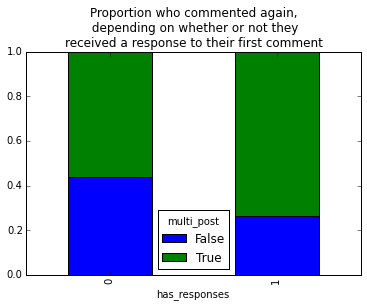

In [42]:
response_crosstab_scaled.T.plot(kind="bar", stacked=True)
plt.title('Proportion who commented again,\n depending on whether or not they \nreceived a response to their first comment')

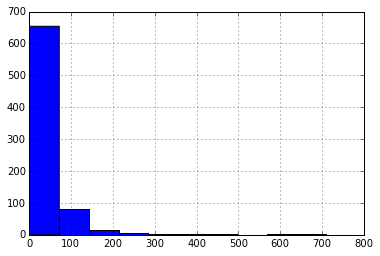

In [43]:
first_post.word_count.hist()

In [44]:
word_count_discrete = pd.cut(first_post.word_count, [0,50,100,150,200,800])

In [45]:
word_count_crosstab = pd.crosstab(multi_post, word_count_discrete)
word_count_crosstab

word_count,"(0, 50]","(50, 100]","(100, 150]","(150, 200]","(200, 800]"
multi_post,,,,,
False,233,29,12,4,6
True,367,68,31,7,11


In [46]:
word_count_crosstab_scaled = word_count_crosstab / word_count_crosstab.sum(axis=0)
word_count_crosstab_scaled

word_count,"(0, 50]","(50, 100]","(100, 150]","(150, 200]","(200, 800]"
multi_post,,,,,
False,0.388333,0.298969,0.27907,0.363636,0.352941
True,0.611667,0.701031,0.72093,0.636364,0.647059


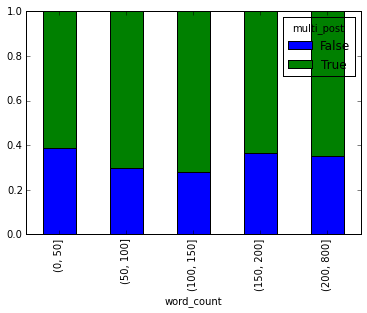

In [47]:
word_count_crosstab_scaled.T.plot(kind="bar", stacked=True)

More responses to mid-length comments -- consider feature for mid-length comments

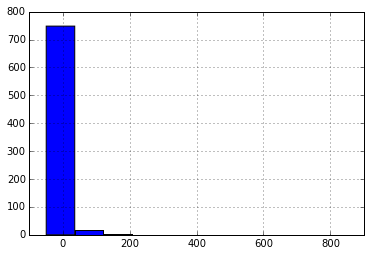

In [48]:
first_post.ups.hist()

In [49]:
ups_discrete = pd.cut(first_post.ups, [-100,-0.5,0.5,10,100,1000])

In [50]:
ups_crosstab = pd.crosstab(multi_post, ups_discrete)
ups_crosstab

ups,"(-100, -0.5]","(-0.5, 0.5]","(0.5, 10]","(10, 100]","(100, 1000]"
multi_post,,,,,
False,28,24,215,15,2
True,44,38,350,45,7


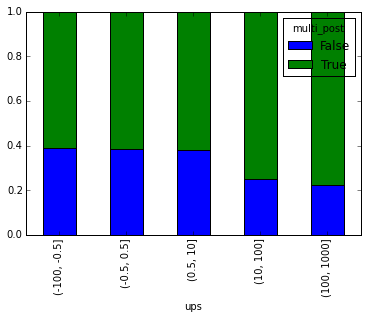

In [51]:
ups_crosstab_scaled = ups_crosstab / ups_crosstab.sum(axis=0)
ups_crosstab_scaled.T.plot(kind="bar", stacked=True)

Highly upvoted first_post more likely to repost

Are ups and has_responses collinear?

In [52]:
ups_vs_has_responses = pd.crosstab(ups_discrete, first_post.has_responses)
ups_vs_has_responses.T

ups,"(-100, -0.5]","(-0.5, 0.5]","(0.5, 10]","(10, 100]","(100, 1000]"
has_responses,,,,,
0,35,44,369,11,0
1,37,18,196,49,9


In [53]:
ups_vs_has_responses_scaled = ups_vs_has_responses.T / ups_vs_has_responses.sum(axis=1)
ups_vs_has_responses_scaled

ups,"(-100, -0.5]","(-0.5, 0.5]","(0.5, 10]","(10, 100]","(100, 1000]"
has_responses,,,,,
0,0.486111,0.709677,0.653097,0.183333,0
1,0.513889,0.290323,0.346903,0.816667,1


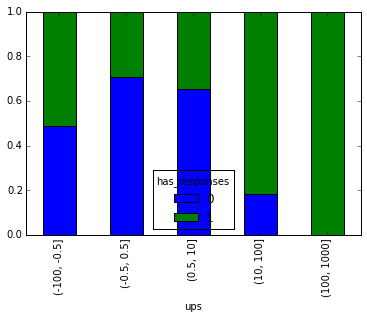

In [54]:
ups_vs_has_responses_scaled.T.plot(kind="bar", stacked=True)

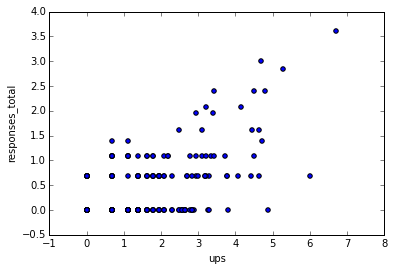

In [55]:
first_post.apply(np.log).plot('ups','responses_total', kind="scatter")

More upvotes is correlated with having responses